In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math

from trainer import Trainer
from model import LSTM

<IPython.core.display.Javascript object>


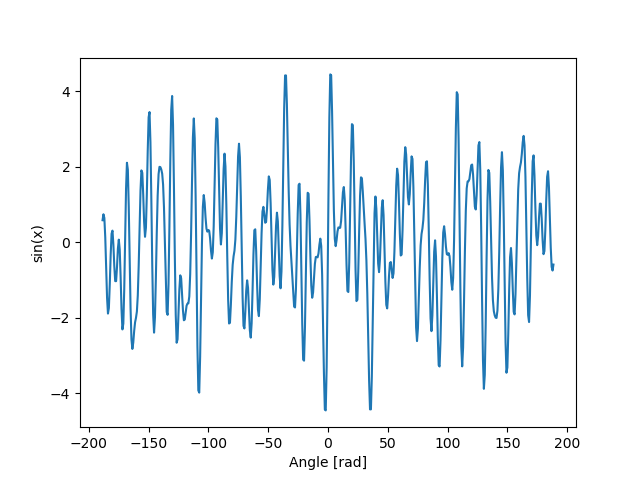

In [105]:
%matplotlib notebook
x = np.linspace(-60*np.pi, 60*np.pi, 500)
out = np.sin(x)+np.sin(0.71*x)+np.sin(0.12*x)+np.sin(0.32*x)+np.sin(0.66*x)+np.sin(0.48*x)
plt.plot(x, out)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()

In [57]:
input_seq_len = 19
output_seq_len = 2
shift_per_batch = 1
epochs = 100
batch_size = 16

batch_num = (len(out)-input_seq_len+shift_per_batch)/shift_per_batch - output_seq_len

x_in = np.array([out[i*shift_per_batch:i*shift_per_batch+input_seq_len] 
           for i in range(int(batch_num))])

y_in = np.array([out[i*shift_per_batch+input_seq_len:i*shift_per_batch+input_seq_len+output_seq_len] 
           for i in range(int(batch_num))])

x_train = torch.from_numpy(x_in[:round(x_in.shape[0]*0.7),:]).t().unsqueeze(-1).float()
x_test = torch.from_numpy(x_in[round(x_in.shape[0]*0.7):,:]).t().unsqueeze(-1).float()
y_train = torch.from_numpy(y_in[:round(y_in.shape[0]*0.7),:]).t().float()
y_test = torch.from_numpy(y_in[round(y_in.shape[0]*0.7):,:]).t().float()

x_full = torch.from_numpy(x_in).t().unsqueeze(-1).float()
y_full = torch.from_numpy(y_in).t().float()

In [58]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_full.shape, y_full.shape

(torch.Size([19, 336, 1]),
 torch.Size([19, 144, 1]),
 torch.Size([2, 336]),
 torch.Size([2, 144]),
 torch.Size([19, 480, 1]),
 torch.Size([2, 480]))

In [5]:
trainer = Trainer(input_size = 1,
                  hidden_size = 60,
                  batch_size = batch_size,
                  output_dim = output_seq_len, 
                  num_layers = 2,
                  learning_rate = 0.01,
                  seq_len = input_seq_len)

In [6]:
for t in range(epochs):
    loss_train = trainer.learn(x_train,y_train)
    loss_test, _ = trainer.evaluate(x_test,y_test)
    print('epoch = {} - train loss ---> {:05f} - val loss ---> {:05f}'.format(t,loss_train,loss_test))

epoch = 0 - train loss ---> 3.023955 - val loss ---> 2.998224
epoch = 1 - train loss ---> 3.044914 - val loss ---> 2.900359
epoch = 2 - train loss ---> 2.902265 - val loss ---> 2.762871
epoch = 3 - train loss ---> 2.775739 - val loss ---> 2.628852
epoch = 4 - train loss ---> 2.657527 - val loss ---> 2.514257
epoch = 5 - train loss ---> 2.553968 - val loss ---> 2.317672
epoch = 6 - train loss ---> 2.340225 - val loss ---> 2.118781
epoch = 7 - train loss ---> 2.109777 - val loss ---> 1.847954
epoch = 8 - train loss ---> 1.811083 - val loss ---> 1.492804
epoch = 9 - train loss ---> 1.445396 - val loss ---> 1.288787
epoch = 10 - train loss ---> 1.233864 - val loss ---> 1.508124
epoch = 11 - train loss ---> 1.291288 - val loss ---> 1.169072
epoch = 12 - train loss ---> 1.037951 - val loss ---> 0.991889
epoch = 13 - train loss ---> 0.833471 - val loss ---> 0.872680
epoch = 14 - train loss ---> 0.722256 - val loss ---> 0.838441
epoch = 15 - train loss ---> 0.705574 - val loss ---> 0.785060
ep

In [110]:
def get_prediction_batch(x,y,shift,input_size,output_size, lookahead):
    predictions = []
    for i in range(round((lookahead-output_size+shift)/shift)):
        out_pred = trainer.predict(x)
        x_shifted = torch.roll(x, -shift)
        x_shifted[:,-shift:,:] = x[:,-shift:,:]
        for i in range(shift,0,-1):
            new_col = torch.roll(x[:,-i,:], -shift)
            if i == shift:
                new_col[-shift:] = out_pred[:shift,-1].unsqueeze(1)
                x_shifted[:,-i,:] = new_col
            else:
                new_col[-shift:] = torch.cat((x_shifted[-1:,-i+1],out_pred[:shift-1,-i+1].unsqueeze(1)))
                x_shifted[:,-i,:] = new_col
        x = x_shifted
        predictions.append(out_pred[:,-1])
    return x, predictions

In [121]:
x_full.shape

torch.Size([19, 480, 1])

In [115]:
def get_prediction(x, shift ,output_size, lookahead):
    outputs = []
    init_hidden = 479
    for i in range(round(lookahead/output_size) + init_hidden):
        if i == 0:
            trainer.model.hidden = (torch.zeros(trainer.model.num_layers,
                                                1,
                                                trainer.model.hidden_dim),
                                    torch.zeros(trainer.model.num_layers,
                                                1,
                                                trainer.model.hidden_dim))
        if i < init_hidden + 1:
            input_model = x[:,i-(init_hidden+1)]
            output = trainer.predict(input_model.unsqueeze(2))
        else:
            input_model = torch.roll(input_model,-output_size)
            input_model[-output.shape[0]:] = output
            output = trainer.predict(input_model.unsqueeze(2))
        outputs += [output]
        
    return torch.cat(outputs[init_hidden:]).numpy()

In [116]:
lookahead = 50
predictions = get_prediction(x_full,shift_per_batch,output_seq_len,lookahead)
predictions.shape

(50, 1)

In [117]:
def extend(x, lookahead):
    diff_x = x[-1]-x[-2]
    x_new = x[-1] + diff_x
    extended = []

    for i in range(lookahead):
        extended.append(x_new)
        x_new += diff_x

    extended = np.array(extended)
    
    return np.append(x, extended)

<IPython.core.display.Javascript object>


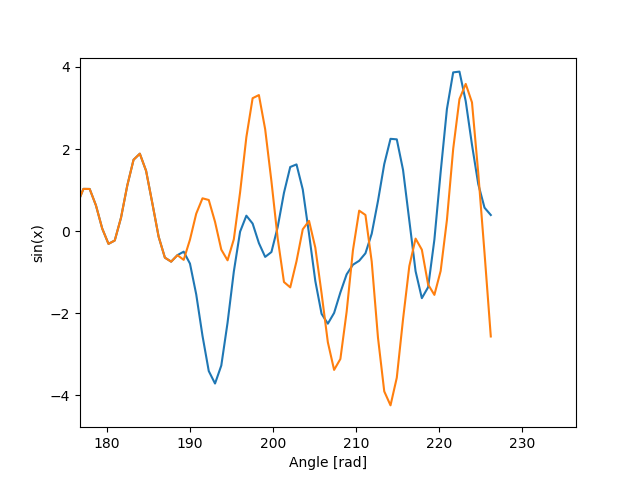

In [118]:
%matplotlib notebook
x = np.linspace(-60*np.pi, 60*np.pi, 500)
x_new = extend(x,lookahead)
out_new = np.sin(x_new)+np.sin(0.71*x_new)+np.sin(0.12*x_new)+np.sin(0.32*x_new)+np.sin(0.66*x_new)+np.sin(0.48*x_new)
out_pred = np.append(out, predictions)
plt.plot(x_new, out_new)
plt.plot(x_new, out_pred)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()